# Import

In [869]:
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as f
import torch.nn.functional as func
import hdf5storage
from PIL import Image
from skimage.metrics import structural_similarity
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from pytorchtools import EarlyStopping
import scipy
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import umap
import umap.plot
import bokeh
from bokeh.io import output_notebook
from bokeh.resources import INLINE

init_notebook_mode(connected=True)
%matplotlib inline
output_notebook(INLINE)

Loading BokehJS ...

# Behavioral

## Init

In [509]:
Behav = pd.DataFrame(data=[], columns=['Sub', 'Ses', 'Trial', 'Type', 'Response', 'RT', 'Stim', 'CharIndex', 'KindIndex'])
for iSub in [2,3,4,6,7,8]:
    for iSes in [1,2,3]:
        for iRun in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
#             try:
                mat = hdf5storage.loadmat('ind/sub0'+str(iSub)+'/train/Sub0'+str(iSub)+'_Session0'+str(iSes)+'_Set'+'{:02d}'.format(iRun)+'.mat')
                try:
                    ForceRT = mat['saveData'][0][0][0][0]
                    ChoiceRT = mat['saveData'][0][0][1][0]
                    Response = mat['saveData'][0][0][2][0][0][0][0]
                    ChoiseTrialNr = mat['saveData'][0][0][3][0]
                    ChoiseStim = mat['saveData'][0][0][4]
                    ForceStim = mat['saveData'][0][0][5]
                except:
                    ForceRT = mat['saveData'][0][0][0]
                    ChoiceRT = mat['saveData'][0][1][0]
                    Response = mat['saveData'][0][2][0][0][0]
                    ChoiseTrialNr = np.array([int(el) for el in mat['saveData'][0][3][0]])
                    ChoiseStim = np.array([el[0] for el in mat['saveData'][0][4]])
                    ForceStim = np.array([el[0] for el in mat['saveData'][0][5]])

                Type = np.array(['Force']*ForceRT.shape[0])
                Type[ChoiseTrialNr-1] = 'Choic'
                RT = np.full(ForceRT.shape[0], fill_value=np.nan)
                RT[np.where(Type == 'Force')[0]] = ForceRT[np.where(Type == 'Force')[0]]
                RT[np.where(Type == 'Choic')[0]] = ChoiceRT[np.where(Type == 'Choic')[0]]
                Stim = np.array(['        ']*ForceRT.shape[0])
                Stim[np.where(Type == 'Force')[0]] = ForceStim
                Stim[np.where(Type == 'Choic')[0]] = ChoiseStim
                char_index = [int(el.split('_')[0]) for el in Stim]
                kind_index = [int(el.split('_')[-1].split('.')[0]) for el in Stim]
                Behav = Behav.append(pd.DataFrame(data={'Sub':iSub, 'Ses':iSes, 'Trial':iRun, 'Type':Type, 'RT':RT, 
                                                                                'Response':Response ,'Stim':Stim, 'CharIndex':char_index, 
                                                                                'KindIndex':kind_index}))
#                 print('ind/sub0'+str(iSub)+'/train/Sub0'+str(iSub)+'_Session0'+str(iSes)+'_Set'+'{:02d}'.format(iRun)+'.mat')
#             except:
#                 pass

Behav['Value'] = np.nan
Behav.loc[(Behav['Sub'].isin([1,2,3,4])) & Behav['CharIndex'].isin([1,2,3,4]), ['Value']] = 'Good'
Behav.loc[(Behav['Sub'].isin([1,2,3,4])) & Behav['CharIndex'].isin([5,6,7,8]), ['Value']] = 'Bad'
Behav.loc[(Behav['Sub'].isin([5,6,7,8])) & Behav['CharIndex'].isin([1,2,3,4]), ['Value']] = 'Bad'
Behav.loc[(Behav['Sub'].isin([5,6,7,8])) & Behav['CharIndex'].isin([5,6,7,8]), ['Value']] = 'Good'
Behav.loc[Behav['RT'] == np.inf, 'RT'] = np.nan
Behav.loc[Behav['RT'] <= 0, 'RT'] = np.nan
Behav

Sub Ses Trial   Type  Response        RT      Stim CharIndex KindIndex  \
0    2   1     1  Force       0.0  1.321960  8_01.png         8         1   
1    2   1     1  Force       0.0  0.809955  6_01.png         6         1   
2    2   1     1  Choic       1.0  0.616169  8_01.png         8         1   
3    2   1     1  Force       1.0  0.919050  4_01.png         4         1   
4    2   1     1  Force       1.0  0.879855  3_01.png         3         1   
..  ..  ..   ...    ...       ...       ...       ...       ...       ...   
75   8   3    16  Choic       1.0  0.417944  1_16.png         1        16   
76   8   3    16  Force       0.0  0.244262  3_16.png         3        16   
77   8   3    16  Force       1.0  0.252016  6_16.png         6        16   
78   8   3    16  Force       1.0  0.644002  5_16.png         5        16   
79   8   3    16  Force       0.0  0.293192  2_16.png         2        16   

   Value  
0    Bad  
1    Bad  
2    Bad  
3   Good  
4   Good  
..   ...  
75   Bad  
76   Bad  
77  Good  
78  Good  
79   Bad  

[23040 rows x 10 columns]

## Good vs Bad

In [833]:
ToPlot = Behav.loc[(Behav['Type'] == 'Choic')].groupby(['Ses','Value'])['Response'].agg(['mean', 'std', 'count'])
ToPlot['SEM'] = ToPlot['std']/ToPlot['count'].apply(np.sqrt)
fig = go.Figure()
fig.add_trace(go.Bar(
    name='Good',
    x=['Day 1','Day 2','Day 3'], 
    y=ToPlot['mean'][:,'Good'],
    error_y=dict(type='data', array=ToPlot['SEM'][:,'Good'])
))
fig.add_trace(go.Bar(
    name='Bad',
    x=['Day 1','Day 2','Day 3'], 
    y=ToPlot['mean'][:,'Bad'],
    error_y=dict(type='data', array=ToPlot['SEM'][:,'Bad'])
))
fig.update_layout(yaxis_title='Accuracy (%)', title={'text':'Choice Accuracy Per Day','y':0.97,'x':0.5,'xanchor':'center','yanchor':'top'},
                  yaxis=dict(range=[0.94, 1]), barmode='group',width=600, margin = dict(t=50, l=0, r=0, b=0))
fig.show()

In [834]:
ToPlot = Behav.loc[(Behav['Type'] == 'Choic')].groupby(['Value'])['Response'].agg(['mean', 'std', 'count'])
ToPlot['SEM'] = ToPlot['std']/ToPlot['count'].apply(np.sqrt)
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Good','Bad'],
    y=[ToPlot['mean']['Good'], ToPlot['mean']['Bad']],
    marker_color=['royalblue','tomato'],
    error_y=dict(type='data', array=[ToPlot['SEM']['Good'], ToPlot['SEM']['Bad']],
)))
fig.update_layout(yaxis_title='Accuracy (%)', title={'text':'Choice Accuracy','y':0.97,'x':0.5,'xanchor':'center','yanchor':'top'},
                  yaxis=dict(range=[0.94, 1]), barmode='group',width=200, margin = dict(t=50, l=0, r=0, b=0))
fig.show()

In [835]:
ToPlot = Behav.loc[(Behav['Type'] == 'Choic')].groupby(['Ses','Value'])['RT'].agg(['mean', 'std', 'count'])
ToPlot['SEM'] = ToPlot['std']/ToPlot['count'].apply(np.sqrt)
fig = go.Figure()
fig.add_trace(go.Bar(
    name='Good',
    x=['Day 1','Day 2','Day 3'], 
    y=ToPlot['mean'][:,'Good'],
    error_y=dict(type='data', array=ToPlot['SEM'][:,'Good'])
))
fig.add_trace(go.Bar(
    name='Bad',
    x=['Day 1','Day 2','Day 3'], 
    y=ToPlot['mean'][:,'Bad'],
    error_y=dict(type='data', array=ToPlot['SEM'][:,'Bad'])
))
fig.update_layout(yaxis_title='RT (sec)', title={'text':'Choice RT Per Day','y':0.97,'x':0.5,'xanchor':'center','yanchor':'top'},
                  yaxis=dict(range=[0.5, 0.58]), barmode='group',width=600, margin = dict(t=50, l=0, r=0, b=0))
fig.show()

In [836]:
ToPlot = Behav.loc[(Behav['Type'] == 'Choic')].groupby(['Value'])['RT'].agg(['mean', 'std', 'count'])
ToPlot['SEM'] = ToPlot['std']/ToPlot['count'].apply(np.sqrt)
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Good','Bad'],
    y=[ToPlot['mean']['Good'], ToPlot['mean']['Bad']],
    marker_color=['royalblue','tomato'],
    error_y=dict(type='data', array=[ToPlot['SEM']['Good'], ToPlot['SEM']['Bad']],
)))
fig.update_layout(yaxis_title='RT (sec)', title={'text':'Choice RT','y':0.97,'x':0.5,'xanchor':'center','yanchor':'top'},
                  yaxis=dict(range=[0.5, 0.58]), barmode='group',width=200, margin = dict(t=50, l=0, r=0, b=0))
fig.show()

In [837]:
ToPlot = Behav.loc[(Behav['Type'] == 'Force')].groupby(['Ses','Value'])['RT'].agg(['mean', 'std', 'count'])
ToPlot['SEM'] = ToPlot['std']/ToPlot['count'].apply(np.sqrt)
fig = go.Figure()
fig.add_trace(go.Bar(
    name='Good',
    x=['Day 1','Day 2','Day 3'], 
    y=ToPlot['mean'][:,'Good'],
    error_y=dict(type='data', array=ToPlot['SEM'][:,'Good'])
))
fig.add_trace(go.Bar(
    name='Bad',
    x=['Day 1','Day 2','Day 3'], 
    y=ToPlot['mean'][:,'Bad'],
    error_y=dict(type='data', array=ToPlot['SEM'][:,'Bad'])
))
fig.update_layout(yaxis_title='RT (sec)', title={'text':'Force RT Per Day','y':0.97,'x':0.5,'xanchor':'center','yanchor':'top'},
                  yaxis=dict(range=[0.38, 0.52]), barmode='group',width=600, margin = dict(t=50, l=0, r=0, b=0))
fig.show()

In [838]:
ToPlot = Behav.loc[(Behav['Type'] == 'Force')].groupby(['Value'])['RT'].agg(['mean', 'std', 'count'])
ToPlot['SEM'] = ToPlot['std']/ToPlot['count'].apply(np.sqrt)
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Good','Bad'],
    y=[ToPlot['mean']['Good'], ToPlot['mean']['Bad']],
    marker_color=['royalblue','tomato'],
    error_y=dict(type='data', array=[ToPlot['SEM']['Good'], ToPlot['SEM']['Bad']],
)))
fig.update_layout(yaxis_title='RT (sec)', title={'text':'Force RT','y':0.97,'x':0.5,'xanchor':'center','yanchor':'top'},
                  yaxis=dict(range=[0.38, 0.52]), barmode='group',width=200, margin = dict(t=50, l=0, r=0, b=0))
fig.show()

In [840]:
ToPlot = Behav.loc[(Behav['Type'] == 'Choic')].groupby(['Ses','Value','Trial'])['RT'].agg(['mean', 'std', 'count'])
ToPlot['SEM'] = ToPlot['std']/ToPlot['count'].apply(np.sqrt)
ToPlot = ToPlot.droplevel(0)
fig = go.Figure(
    [
    go.Scatter(
        name='Good',
        y=ToPlot['mean']['Good'],
        mode='lines',
        line=dict(color='royalblue'),),
    go.Scatter(
        y=ToPlot['mean']['Good']+ToPlot['SEM']['Good'],
        mode='lines',
        line=dict(width=0),
        showlegend=False),
    go.Scatter(
        y=ToPlot['mean']['Good']-ToPlot['SEM']['Good'],
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(0, 0, 255, 0.1)',
        fill='tonexty',
        showlegend=False),

    go.Scatter(
        name='Bad',
        y=ToPlot['mean']['Bad'],
        mode='lines',
        line=dict(color='tomato'),),
    go.Scatter(
        y=ToPlot['mean']['Bad']+ToPlot['SEM']['Bad'],
        mode='lines',
        line=dict(width=0),
        showlegend=False),
    go.Scatter(
        y=ToPlot['mean']['Bad']-ToPlot['SEM']['Bad'],
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(255, 0, 0, 0.1)',
        fill='tonexty',
        showlegend=False),
    ], 
)
fig.update_layout(
    title={'text':'Choice RT Per Run','y':0.97,'x':0.5,'xanchor':'center','yanchor':'top'},
    margin = dict(t=50, l=0, r=0, b=0),
    yaxis_title='RT (sec)',
    xaxis_title='Run',
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 16)
)
fig.show()

In [841]:
ToPlot = Behav.loc[(Behav['Type'] == 'Force')].groupby(['Ses','Value','Trial'])['RT'].agg(['mean', 'std', 'count'])
ToPlot['SEM'] = ToPlot['std']/ToPlot['count'].apply(np.sqrt)
ToPlot = ToPlot.droplevel(0)
fig = go.Figure(
    [
    go.Scatter(
        name='Good',
        y=ToPlot['mean']['Good'],
        mode='lines',
        line=dict(color='royalblue'),),
    go.Scatter(
        y=ToPlot['mean']['Good']+ToPlot['SEM']['Good'],
        mode='lines',
        line=dict(width=0),
        showlegend=False),
    go.Scatter(
        y=ToPlot['mean']['Good']-ToPlot['SEM']['Good'],
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(0, 0, 255, 0.1)',
        fill='tonexty',
        showlegend=False),

    go.Scatter(
        name='Bad',
        y=ToPlot['mean']['Bad'],
        mode='lines',
        line=dict(color='tomato'),),
    go.Scatter(
        y=ToPlot['mean']['Bad']+ToPlot['SEM']['Bad'],
        mode='lines',
        line=dict(width=0),
        showlegend=False),
    go.Scatter(
        y=ToPlot['mean']['Bad']-ToPlot['SEM']['Bad'],
        line=dict(width=0),
        mode='lines',
        fillcolor='rgba(255, 0, 0, 0.1)',
        fill='tonexty',
        showlegend=False),
    ], 
)
fig.update_layout(
    title={'text':'Force RT Per Run','y':0.97,'x':0.5,'xanchor':'center','yanchor':'top'},
    margin = dict(t=50, l=0, r=0, b=0),
    yaxis_title='RT (sec)',
    xaxis_title='Run',
    xaxis = dict(
        tickmode = 'linear',
        tick0 = 0,
        dtick = 16)
)
fig.show()

## Char

In [852]:
ToPlot = Behav.loc[(Behav['Type'] == 'Choic')].groupby(['CharIndex'])['Response'].agg(['mean', 'std', 'count'])
ToPlot['SEM'] = ToPlot['std']/ToPlot['count'].apply(np.sqrt)
AccSorted = ToPlot['mean'].sort_values()
ToPlotMeanSorted = ToPlot['mean'].sort_values()
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Char'+str(el) for el in ToPlot['mean'].sort_values().index],
    y=ToPlot['mean'].sort_values(),
    error_y=dict(type='data', array=ToPlot['SEM'].reindex(ToPlot['mean'].sort_values().index),
)))
fig.update_layout(yaxis_title='Accuracy (%)', title={'text':'Choice Accuracy Per Char','y':0.97,'x':0.5,'xanchor':'center','yanchor':'top'},
                  yaxis=dict(range=[0.95, 1]), barmode='group',width=400, margin = dict(t=50, l=0, r=0, b=0))
fig.show()

In [853]:
ToPlot = Behav.loc[(Behav['Type'] == 'Choic')].groupby(['CharIndex'])['RT'].agg(['mean', 'std', 'count'])
ToPlot['SEM'] = ToPlot['std']/ToPlot['count'].apply(np.sqrt)
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Char'+str(el) for el in ToPlot['mean'].reindex(AccSorted.index).index],
    y=ToPlot['mean'].reindex(AccSorted.index),
    error_y=dict(type='data', array=ToPlot['SEM'].reindex(AccSorted.index),
)))
fig.update_layout(yaxis_title='RT (sec)', title={'text':'Choice RT Per Char','y':0.97,'x':0.5,'xanchor':'center','yanchor':'top'},
                  yaxis=dict(range=[0.5, 0.58]), barmode='group',width=400, margin = dict(t=50, l=0, r=0, b=0))
fig.show()

In [855]:
ToPlot = Behav.loc[(Behav['Type'] == 'Force')].groupby(['CharIndex'])['RT'].agg(['mean', 'std', 'count'])
ToPlot['SEM'] = ToPlot['std']/ToPlot['count'].apply(np.sqrt)
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Char'+str(el) for el in ToPlot['mean'].sort_values().index],
    y=ToPlot['mean'].sort_values(),
    error_y=dict(type='data', array=ToPlot['SEM'].reindex(ToPlot['mean'].sort_values().index),
)))
fig.update_layout(yaxis_title='RT (sec)', title={'text':'Force RT Per Char','y':0.97,'x':0.5,'xanchor':'center','yanchor':'top'},
                  yaxis=dict(range=[0.38, 0.52]), barmode='group',width=400, margin = dict(t=50, l=0, r=0, b=0))
fig.show()

## Sub

In [862]:
ToPlot = Behav.loc[(Behav['Type'] == 'Choic')].groupby(['Sub'])['Response'].agg(['mean', 'std', 'count'])
ToPlot['SEM'] = ToPlot['std']/ToPlot['count'].apply(np.sqrt)
AccSorted = ToPlot['mean'].sort_values()
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Sub'+str(el) for el in ToPlot['mean'].sort_values().index],
    y=ToPlot['mean'].sort_values(),
    error_y=dict(type='data', array=ToPlot['SEM'].reindex(ToPlot['mean'].sort_values().index),
)))
fig.update_layout(yaxis_title='Accuracy (%)', title={'text':'Choice Accuracy Per Sub','y':0.97,'x':0.5,'xanchor':'center','yanchor':'top'},
                  yaxis=dict(range=[0.9, 1]), barmode='group',width=400, margin = dict(t=50, l=0, r=0, b=0))
fig.show()

In [861]:
ToPlot = Behav.loc[(Behav['Type'] == 'Choic')].groupby(['Sub'])['RT'].agg(['mean', 'std', 'count'])
ToPlot['SEM'] = ToPlot['std']/ToPlot['count'].apply(np.sqrt)
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Sub'+str(el) for el in ToPlot['mean'].reindex(AccSorted.index).index],
    y=ToPlot['mean'].reindex(AccSorted.index),
    error_y=dict(type='data', array=ToPlot['SEM'].reindex(AccSorted.index),
)))
fig.update_layout(yaxis_title='RT (sec)', title={'text':'Choice Trial RT Per Sub','y':0.97,'x':0.5,'xanchor':'center','yanchor':'top'},
                  yaxis=dict(range=[0.4, 0.8]), barmode='group',width=400, margin = dict(t=50, l=0, r=0, b=0))
fig.show()

In [863]:
ToPlot = Behav.loc[(Behav['Type'] == 'Force')].groupby(['Sub'])['RT'].agg(['mean', 'std', 'count'])
ToPlot['SEM'] = ToPlot['std']/ToPlot['count'].apply(np.sqrt)
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['Sub'+str(el) for el in ToPlot['mean'].sort_values().index],
    y=ToPlot['mean'].sort_values(),
    error_y=dict(type='data', array=ToPlot['SEM'].reindex(ToPlot['mean'].sort_values().index),
)))
fig.update_layout(yaxis_title='RT (sec)', title={'text':'Force RT Per Sub','y':0.97,'x':0.5,'xanchor':'center','yanchor':'top'},
                  yaxis=dict(range=[0.35, 0.55]), barmode='group',width=400, margin = dict(t=50, l=0, r=0, b=0))
fig.show()

# fMRI

## Indices

In [88]:
fMRI = pd.DataFrame(data=[], columns=['Sub', 'Ses', 'Run', 'Block', 'Stim', 'CharIndex', 'KindIndex'])
for iSub in [1,2,3,4,6,7,8]:
    for iSes in [1,2]:
        for iRun in [1,2,3,4,5,6,7,8]:
            try:
                mat = hdf5storage.loadmat('ind/sub0'+str(iSub)+'/fmri/fMRIData_0'+str(iSub)+'_session0'+str(iSes)+'_set0'+str(iRun)+'.mat')
            except:
                mat = hdf5storage.loadmat('ind/sub0'+str(iSub)+'/fmri/fMRIData_'+str(iSub)+'_session'+str(iSes)+'_set'+str(iRun)+'.mat')
            Sub = iSub
            Ses = iSes
            Run = iRun
            try:
                rndperm = list(mat['output'][0][0][4][0])
            except:
                rndperm = list(mat['output'][0][4][0])
            rndperm = [int(el-1) for el in rndperm]
            try:
                Stim = [el[0] for el in mat['output'][0][0][3][0]]
            except:
                Stim = [el[0][0] for el in mat['output'][0][3][0]]
            Stim = [el.split('/')[-1] for el in Stim]
            char_index = [int(el.split('_')[0]) for el in Stim]
            kind_index = [int(el.split('_')[-1].split('.')[0]) for el in Stim]
            Stim = np.array(Stim)[rndperm]
            char_index = np.array(char_index)[rndperm]
            kind_index = np.array(kind_index)[rndperm]
            for i in range(len(Stim)):
                fMRI = fMRI.append(pd.Series((Sub,Ses,Run,i+1,Stim[i],char_index[i],kind_index[i]), 
                                                           index=fMRI.columns), ignore_index=True)

fMRI['Value'] = np.nan
fMRI.loc[(fMRI['Sub'].isin([1,2,3,4])) & fMRI['CharIndex'].isin([1,2,3,4]), ['Value']] = 1
fMRI.loc[(fMRI['Sub'].isin([1,2,3,4])) & fMRI['CharIndex'].isin([5,6,7,8]), ['Value']] = 0
fMRI.loc[(fMRI['Sub'].isin([5,6,7,8])) & fMRI['CharIndex'].isin([1,2,3,4]), ['Value']] = 0
fMRI.loc[(fMRI['Sub'].isin([5,6,7,8])) & fMRI['CharIndex'].isin([5,6,7,8]), ['Value']] = 1
fMRI

Sub Ses Run Block      Stim CharIndex KindIndex  Value
0      1   1   1     1  1_01.png         1         1    1.0
1      1   1   1     2  2_02.png         2         2    1.0
2      1   1   1     3  3_01.png         3         1    1.0
3      1   1   1     4  4_01.png         4         1    1.0
4      1   1   1     5  5_01.png         5         1    0.0
...   ..  ..  ..   ...       ...       ...       ...    ...
1787   8   2   8    12  1_16.png         1        16    0.0
1788   8   2   8    13  7_16.png         7        16    1.0
1789   8   2   8    14  2_15.png         2        15    0.0
1790   8   2   8    15  6_15.png         6        15    1.0
1791   8   2   8    16  7_15.png         7        15    1.0

[1792 rows x 8 columns]

## Read Data

In [89]:
Subs = [1,2,3,4,6,7,8]
Sess = [1,2]
Rois = ['v1','v2','v3','v1.v2','v1.v2.v3']

MAP_SUB = {sub:i for i, sub in enumerate(Subs)}
MAP_SES = {ses:i for i, ses in enumerate(Sess)}
MAP_ROI = {roi:i for i, roi in enumerate(Rois)}
MAP_STAT = {stat:i for i, stat in enumerate(['Full_Fstat','G_Coef','G_Tstat','G_Fstat','B_Coef','B_Tstat','B_Fstat',
                                           'G-B_Coef','G-B_Tstat','G-B_Fstat','G+B_Coef','G+B_Tstat','G+B_Fstat'])}

fmriRaw = np.full([len(Subs),len(Sess),len(Rois)], fill_value=np.nan , dtype=object)
StatRaw = np.full([len(Subs),len(Sess),len(Rois)], fill_value=np.nan , dtype=object)

for iSub in tqdm(Subs):
    for iSes in Sess:
        for iRoi in Rois:
            StatPath = '/media/hdd1/users/sharifi/fmri/sub0'+str(iSub)+'/sess0'+str(iSes)+'/results.mni.noblur/stats.data.'+iRoi+'.sub0'+str(iSub)+'.sess0'+str(iSes)+'.txt'
            RoiPath = '/media/hdd1/users/sharifi/fmri/sub0'+str(iSub)+'/sess0'+str(iSes)+'/results.mni.noblur/roi.data.'+iRoi+'.sub0'+str(iSub)+'.sess0'+str(iSes)+'.txt'
            fmriRaw[MAP_SUB[iSub],MAP_SES[iSes],MAP_ROI[iRoi]] = np.loadtxt(RoiPath)
            StatRaw[MAP_SUB[iSub],MAP_SES[iSes],MAP_ROI[iRoi]] = np.loadtxt(StatPath)
            

100%|██████████| 7/7 [01:41<00:00, 14.56s/it]


In [488]:
fMRI['v1'] = np.nan
fMRI['v2'] = np.nan
fMRI['v3'] = np.nan
fMRI['v1'] = fMRI['v1'].astype(object)
fMRI['v2'] = fMRI['v2'].astype(object)
fMRI['v3'] = fMRI['v3'].astype(object)
fMRI['v1Sel+'] = np.nan
fMRI['v2Sel+'] = np.nan
fMRI['v3Sel+'] = np.nan
fMRI['v1Sel+'] = fMRI['v1Sel+'].astype(object)
fMRI['v2Sel+'] = fMRI['v2Sel+'].astype(object)
fMRI['v3Sel+'] = fMRI['v3Sel+'].astype(object)
fMRI['v1Sel-'] = np.nan
fMRI['v2Sel-'] = np.nan
fMRI['v3Sel-'] = np.nan
fMRI['v1Sel-'] = fMRI['v1Sel-'].astype(object)
fMRI['v2Sel-'] = fMRI['v2Sel-'].astype(object)
fMRI['v3Sel-'] = fMRI['v3Sel-'].astype(object)

In [489]:
FeatureNum = 100
for iRow in range(len(fMRI)):
    thisRow = fMRI.iloc[iRow]
    iStart = ((thisRow['Run']-1)*16*10)+((thisRow['Block']-1)*10)
    fMRI.at[iRow,'v1'] = fmriRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v1']][:,iStart:iStart+10]
    fMRI.at[iRow,'v2'] = fmriRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v2']][:,iStart:iStart+10]
    fMRI.at[iRow,'v3'] = fmriRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v3']][:,iStart:iStart+10]
    
    tStat = StatRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v1']][:,MAP_STAT['G+B_Tstat']]
    tCoef = StatRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v1']][:,MAP_STAT['G+B_Coef']]
    tCoef = np.abs(tCoef[np.where((tStat< -2) | (tStat > 2))[0]])
    ArgSort = np.argsort(tCoef)[::-1]
    fMRI.at[iRow,'v1Sel+'] = fmriRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v1']][ArgSort[:FeatureNum],iStart:iStart+10]
    
    tStat = StatRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v2']][:,MAP_STAT['G+B_Tstat']]
    tCoef = StatRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v2']][:,MAP_STAT['G+B_Coef']]
    tCoef = np.abs(tCoef[np.where((tStat< -2) | (tStat > 2))[0]])
    ArgSort = np.argsort(tCoef)[::-1]
    fMRI.at[iRow,'v2Sel+'] = fmriRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v2']][ArgSort[:FeatureNum],iStart:iStart+10]
    
    tStat = StatRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v3']][:,MAP_STAT['G+B_Tstat']]
    tCoef = StatRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v3']][:,MAP_STAT['G+B_Coef']]
    tCoef = np.abs(tCoef[np.where((tStat< -2) | (tStat > 2))[0]])
    ArgSort = np.argsort(tCoef)[::-1]
    fMRI.at[iRow,'v3Sel+'] = fmriRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v3']][ArgSort[:FeatureNum],iStart:iStart+10]
    
    tStat = StatRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v1']][:,MAP_STAT['G-B_Tstat']]
    tCoef = StatRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v1']][:,MAP_STAT['G-B_Coef']]
    tCoef = np.abs(tCoef[np.where((tStat< -2) | (tStat > 2))[0]])
    ArgSort = np.argsort(tCoef)[::-1]
    fMRI.at[iRow,'v1Sel-'] = fmriRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v1']][ArgSort[:FeatureNum],iStart:iStart+10]
    
    tStat = StatRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v2']][:,MAP_STAT['G-B_Tstat']]
    tCoef = StatRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v2']][:,MAP_STAT['G-B_Coef']]
    tCoef = np.abs(tCoef[np.where((tStat< -2) | (tStat > 2))[0]])
    ArgSort = np.argsort(tCoef)[::-1]
    fMRI.at[iRow,'v2Sel-'] = fmriRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v2']][ArgSort[:FeatureNum],iStart:iStart+10]
    
    tStat = StatRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v3']][:,MAP_STAT['G-B_Tstat']]
    tCoef = StatRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v3']][:,MAP_STAT['G-B_Coef']]
    tCoef = np.abs(tCoef[np.where((tStat< -2) | (tStat > 2))[0]])
    ArgSort = np.argsort(tCoef)[::-1]
    fMRI.at[iRow,'v3Sel-'] = fmriRaw[MAP_SUB[thisRow['Sub']],MAP_SES[thisRow['Ses']],MAP_ROI['v3']][ArgSort[:FeatureNum],iStart:iStart+10]

In [490]:
temp = fMRI.loc[(fMRI['Sub'] == 6) & (fMRI['Ses'] == 2),'v1'].iloc[-2]
temp = np.concatenate((temp,temp[:,-1].reshape((-1,1))),axis=1)
ind = fMRI.index[(fMRI['Sub'] == 6) & (fMRI['Ses'] == 2)].tolist()[-2]
fMRI.at[ind, 'v1'] = temp
fMRI.at[ind+1, 'v1'] = temp

temp = fMRI.loc[(fMRI['Sub'] == 6) & (fMRI['Ses'] == 2),'v2'].iloc[-2]
temp = np.concatenate((temp,temp[:,-1].reshape((-1,1))),axis=1)
ind = fMRI.index[(fMRI['Sub'] == 6) & (fMRI['Ses'] == 2)].tolist()[-2]
fMRI.at[ind, 'v2'] = temp
fMRI.at[ind+1, 'v2'] = temp

temp = fMRI.loc[(fMRI['Sub'] == 6) & (fMRI['Ses'] == 2),'v3'].iloc[-2]
temp = np.concatenate((temp,temp[:,-1].reshape((-1,1))),axis=1)
ind = fMRI.index[(fMRI['Sub'] == 6) & (fMRI['Ses'] == 2)].tolist()[-2]
fMRI.at[ind, 'v3'] = temp
fMRI.at[ind+1, 'v3'] = temp

temp = fMRI.loc[(fMRI['Sub'] == 6) & (fMRI['Ses'] == 2),'v1Sel+'].iloc[-2]
temp = np.concatenate((temp,temp[:,-1].reshape((-1,1))),axis=1)
ind = fMRI.index[(fMRI['Sub'] == 6) & (fMRI['Ses'] == 2)].tolist()[-2]
fMRI.at[ind, 'v1Sel+'] = temp
fMRI.at[ind+1, 'v1Sel+'] = temp

temp = fMRI.loc[(fMRI['Sub'] == 6) & (fMRI['Ses'] == 2),'v2Sel+'].iloc[-2]
temp = np.concatenate((temp,temp[:,-1].reshape((-1,1))),axis=1)
ind = fMRI.index[(fMRI['Sub'] == 6) & (fMRI['Ses'] == 2)].tolist()[-2]
fMRI.at[ind, 'v2Sel+'] = temp
fMRI.at[ind+1, 'v2Sel+'] = temp

temp = fMRI.loc[(fMRI['Sub'] == 6) & (fMRI['Ses'] == 2),'v3Sel+'].iloc[-2]
temp = np.concatenate((temp,temp[:,-1].reshape((-1,1))),axis=1)
ind = fMRI.index[(fMRI['Sub'] == 6) & (fMRI['Ses'] == 2)].tolist()[-2]
fMRI.at[ind, 'v3Sel+'] = temp
fMRI.at[ind+1, 'v3Sel+'] = temp

temp = fMRI.loc[(fMRI['Sub'] == 6) & (fMRI['Ses'] == 2),'v1Sel-'].iloc[-2]
temp = np.concatenate((temp,temp[:,-1].reshape((-1,1))),axis=1)
ind = fMRI.index[(fMRI['Sub'] == 6) & (fMRI['Ses'] == 2)].tolist()[-2]
fMRI.at[ind, 'v1Sel-'] = temp
fMRI.at[ind+1, 'v1Sel-'] = temp

temp = fMRI.loc[(fMRI['Sub'] == 6) & (fMRI['Ses'] == 2),'v2Sel-'].iloc[-2]
temp = np.concatenate((temp,temp[:,-1].reshape((-1,1))),axis=1)
ind = fMRI.index[(fMRI['Sub'] == 6) & (fMRI['Ses'] == 2)].tolist()[-2]
fMRI.at[ind, 'v2Sel-'] = temp
fMRI.at[ind+1, 'v2Sel-'] = temp

temp = fMRI.loc[(fMRI['Sub'] == 6) & (fMRI['Ses'] == 2),'v3Sel-'].iloc[-2]
temp = np.concatenate((temp,temp[:,-1].reshape((-1,1))),axis=1)
ind = fMRI.index[(fMRI['Sub'] == 6) & (fMRI['Ses'] == 2)].tolist()[-2]
fMRI.at[ind, 'v3Sel-'] = temp
fMRI.at[ind+1, 'v3Sel-'] = temp

## Umap

### Voxel as Feature +

In [982]:
UmapData = np.stack(fMRI['v1Sel+'].to_numpy())
UmapData = np.transpose(UmapData, (2, 0, 1))
print(UmapData.shape)
UmapData = UmapData.reshape((UmapData.shape[0]*UmapData.shape[1], UmapData.shape[2]))
UmapDataScaled = StandardScaler().fit_transform(UmapData)
print(UmapData.shape)
mapper = umap.UMAP()
embedding = mapper.fit_transform(UmapDataScaled)
embedding.shape

(10, 1792, 100)
(17920, 100)


(17920, 2)

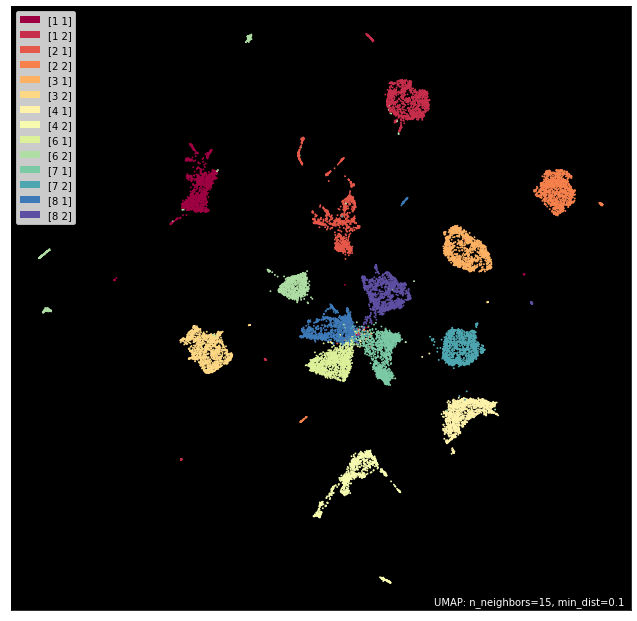

In [983]:
UmapLabel = np.array(fMRI['Ses'].tolist()*10)
UmapLabel = np.array(list(zip(fMRI['Sub'], fMRI['Ses']))*10)
UmapLabel = np.array([str(el) for el in UmapLabel])
p = umap.plot.points(mapper, labels=UmapLabel, background='black')
# umap.plot.show(p)

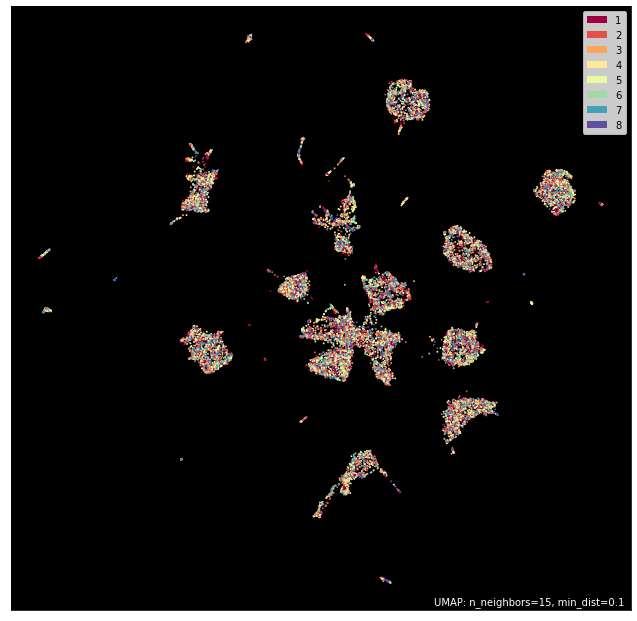

In [984]:
UmapLabel = np.array(fMRI['CharIndex'].tolist()*10)
p = umap.plot.points(mapper, labels=UmapLabel, background='black')
# umap.plot.show(p)

### Voxel as Feature -

In [977]:
UmapData = np.stack(fMRI.loc[fMRI['Ses'] == 2]['v1Sel-'].to_numpy())
UmapData = np.transpose(UmapData, (2, 0, 1))
print(UmapData.shape)
UmapData = UmapData.reshape((UmapData.shape[0]*UmapData.shape[1], UmapData.shape[2]))
UmapDataScaled = StandardScaler().fit_transform(UmapData)
print(UmapData.shape)
mapper = umap.UMAP()
embedding = mapper.fit_transform(UmapDataScaled)
embedding.shape

(10, 896, 100)
(8960, 100)


(8960, 2)

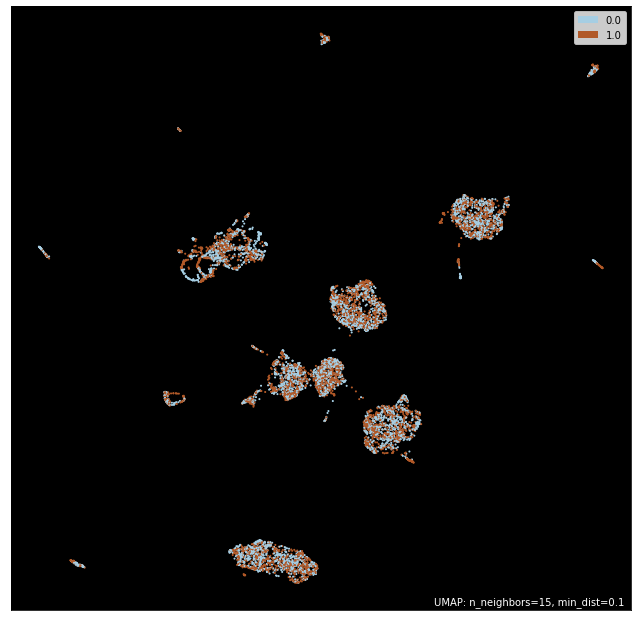

In [978]:
UmapLabel = np.array(fMRI.loc[fMRI['Ses'] == 2]['Value'].tolist()*10)
p = umap.plot.points(mapper, labels=UmapLabel, color_key_cmap='Paired', background='black')
umap.plot.show(p)

### Voxel as Feature Per SubSes + 

In [974]:
iSub = 8
iSes = 2
UmapData = np.stack(fMRI.loc[(fMRI['Sub']==iSub) & (fMRI['Ses']==iSes)]['v1Sel+'].to_numpy())
UmapData = np.transpose(UmapData, (2, 0, 1))
print(UmapData.shape)
UmapData = UmapData.reshape((UmapData.shape[0]*UmapData.shape[1], UmapData.shape[2]))
UmapDataScaled = StandardScaler().fit_transform(UmapData)
print(UmapData.shape)
mapper = umap.UMAP()
embedding = mapper.fit_transform(UmapDataScaled)
embedding.shape

(10, 128, 100)
(1280, 100)


(1280, 2)

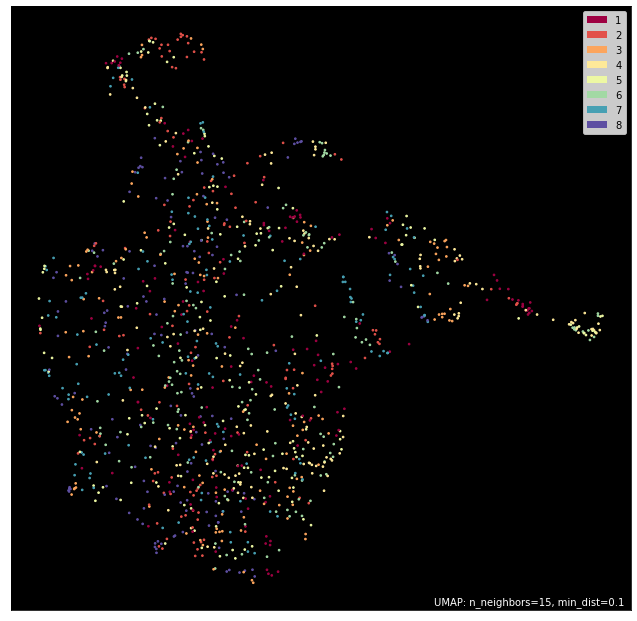

In [975]:
UmapLabel = np.array(fMRI.loc[(fMRI['Sub']==iSub) & (fMRI['Ses']==iSes)]['CharIndex'].tolist()*10)
p = umap.plot.points(mapper, labels=UmapLabel, background='black')
# umap.plot.show(p)

### Voxel as Feature Per SubSes -

In [979]:
iSub = 8
iSes = 2
UmapData = np.stack(fMRI.loc[(fMRI['Sub']==iSub) & (fMRI['Ses']==iSes)]['v1Sel-'].to_numpy())
UmapData = np.transpose(UmapData, (2, 0, 1))
print(UmapData.shape)
UmapData = UmapData.reshape((UmapData.shape[0]*UmapData.shape[1], UmapData.shape[2]))
UmapDataScaled = StandardScaler().fit_transform(UmapData)
print(UmapData.shape)
mapper = umap.UMAP()
embedding = mapper.fit_transform(UmapDataScaled)
embedding.shape

(10, 128, 100)
(1280, 100)


(1280, 2)

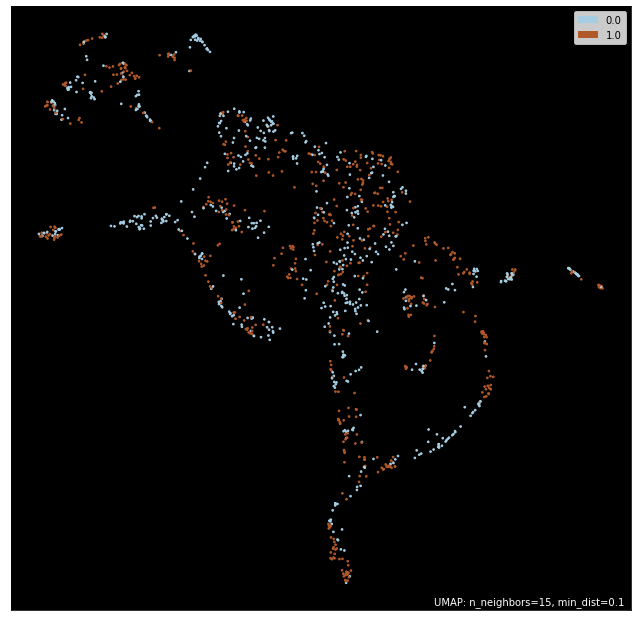

In [981]:
UmapLabel = np.array(fMRI.loc[(fMRI['Sub']==iSub) & (fMRI['Ses']==iSes)]['Value'].tolist()*10)
p = umap.plot.points(mapper, labels=UmapLabel, color_key_cmap='Paired', background='black')
umap.plot.show(p)

### Voxel as Observation Per Char 

In [985]:
iRoi = 'v1'
del UmapRaw
UmapRaw = np.full([len(Subs),len(Sess),len(fMRI['CharIndex'].unique()),16,fMRI[iRoi].iloc[0].shape[0],10], fill_value=np.nan , dtype=object)
UmapRawSub = np.full([len(Subs),len(Sess),len(fMRI['CharIndex'].unique()),16,fMRI[iRoi].iloc[0].shape[0],10], fill_value=np.nan , dtype=object)
UmapRawSes = np.full([len(Subs),len(Sess),len(fMRI['CharIndex'].unique()),16,fMRI[iRoi].iloc[0].shape[0],10], fill_value=np.nan , dtype=object)
UmapRawCharIndex = np.full([len(Subs),len(Sess),len(fMRI['CharIndex'].unique()),16,fMRI[iRoi].iloc[0].shape[0],10], fill_value=np.nan , dtype=object)

for iSub in fMRI['Sub'].unique():
    for iSes in fMRI['Ses'].unique():
        for iCharIndex in fMRI['CharIndex'].unique():
            UmapRaw[MAP_SUB[iSub],iSes-1,iCharIndex-1,:,:,:] = np.stack(fMRI.loc[(fMRI['Sub']==iSub) & (fMRI['Ses']==iSes) & (fMRI['CharIndex']==iCharIndex)][iRoi].to_numpy())
            UmapRawSub[MAP_SUB[iSub],iSes-1,iCharIndex-1,:,:,:] = iSub
            UmapRawSes[MAP_SUB[iSub],iSes-1,iCharIndex-1,:,:,:] = iSes
            UmapRawCharIndex[MAP_SUB[iSub],iSes-1,iCharIndex-1,:,:,:] = iCharIndex

In [986]:
UmapData = UmapRaw.copy()
UmapCharIndex = UmapRawCharIndex.copy()
UmapData = np.transpose(UmapData, (2, 4, 0, 1, 3, 5))
UmapCharIndex = np.transpose(UmapCharIndex, (2, 4, 0, 1, 3, 5))
print(UmapData.shape)
UmapData = UmapData.reshape((UmapData.shape[0]*UmapData.shape[1], UmapData.shape[2]*UmapData.shape[3]*UmapData.shape[4]*UmapData.shape[5]))
UmapCharIndex = UmapCharIndex.reshape((UmapCharIndex.shape[0]*UmapCharIndex.shape[1], UmapCharIndex.shape[2]*UmapCharIndex.shape[3]*UmapCharIndex.shape[4]*UmapCharIndex.shape[5]))
UmapDataScaled = StandardScaler().fit_transform(UmapData)
print(UmapData.shape)
mapper = umap.UMAP()
embedding = mapper.fit_transform(UmapDataScaled)
embedding.shape

(8, 3384, 7, 2, 16, 10)
(27072, 2240)


(27072, 2)

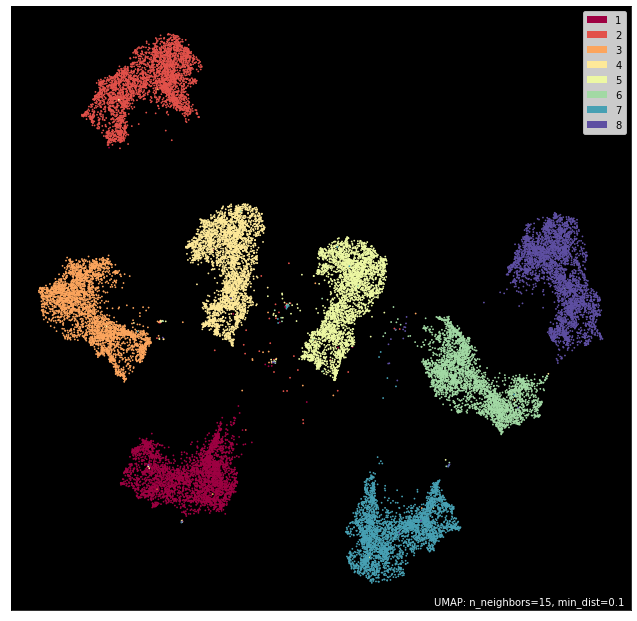

In [987]:
p = umap.plot.points(mapper, labels=UmapCharIndex[:,0], background='black')
umap.plot.show(p)

### Voxel as Observation Per Sub

In [829]:
UmapData = UmapRaw.copy()
UmapSub = UmapRawSub.copy()
print(UmapData.shape)
UmapData = np.transpose(UmapData, (0, 4, 2, 1, 3, 5))
UmapSub = np.transpose(UmapSub, (0, 4, 2, 1, 3, 5))
print(UmapData.shape)
UmapData = UmapData.reshape((UmapData.shape[0]*UmapData.shape[1], UmapData.shape[2]*UmapData.shape[3]*UmapData.shape[4]*UmapData.shape[5]))
UmapSub = UmapSub.reshape((UmapSub.shape[0]*UmapSub.shape[1], UmapSub.shape[2]*UmapSub.shape[3]*UmapSub.shape[4]*UmapSub.shape[5]))
UmapDataScaled = StandardScaler().fit_transform(UmapData)
print(UmapData.shape)
mapper = umap.UMAP()
embedding = mapper.fit_transform(UmapDataScaled)
embedding.shape

(7, 2, 8, 16, 3384, 10)
(7, 3384, 8, 2, 16, 10)
(23688, 2560)


(23688, 2)

In [830]:
p = umap.plot.interactive(mapper, labels=UmapSub[:,0], background='black', point_size=1)
umap.plot.show(p)

### Voxel as Observation Per Char Kind

In [850]:
iKind = 4
UmapData = UmapRaw[:,:,:,iKind,:,:].copy()
UmapCharIndex = UmapRawCharIndex[:,:,:,iKind,:,:].copy()
UmapData = np.transpose(UmapData, (2, 3, 0, 1, 4))
UmapCharIndex = np.transpose(UmapCharIndex, (2, 3, 0, 1, 4))
print(UmapData.shape)
UmapData = UmapData.reshape((UmapData.shape[0]*UmapData.shape[1], UmapData.shape[2]*UmapData.shape[3]*UmapData.shape[4]))
UmapCharIndex = UmapCharIndex.reshape((UmapCharIndex.shape[0]*UmapCharIndex.shape[1], UmapCharIndex.shape[2]*UmapCharIndex.shape[3]*UmapCharIndex.shape[4]))
UmapDataScaled = StandardScaler().fit_transform(UmapData)
print(UmapData.shape)
mapper = umap.UMAP()
embedding = mapper.fit_transform(UmapDataScaled)
embedding.shape

(8, 3384, 7, 2, 10)
(27072, 140)


(27072, 2)

In [851]:
p = umap.plot.interactive(mapper, labels=UmapCharIndex[:,0], background='black', point_size=1)
umap.plot.show(p)

### Voxel as Observation Per Session

In [1002]:
iSes = 0
UmapData = UmapRaw[:,iSes,:,:,:,:].copy()
UmapCharIndex = UmapRawCharIndex[:,iSes,:,:,:,:].copy()
UmapData = np.transpose(UmapData, (1, 3, 0, 2, 4))
UmapCharIndex = np.transpose(UmapCharIndex, (1, 3, 0, 2, 4))
print(UmapData.shape)
UmapData = UmapData.reshape((UmapData.shape[0]*UmapData.shape[1], UmapData.shape[2]*UmapData.shape[3]*UmapData.shape[4]))
UmapCharIndex = UmapCharIndex.reshape((UmapCharIndex.shape[0]*UmapCharIndex.shape[1], UmapCharIndex.shape[2]*UmapCharIndex.shape[3]*UmapCharIndex.shape[4]))
UmapDataScaled = StandardScaler().fit_transform(UmapData)
print(UmapData.shape)
mapper = umap.UMAP()
embedding = mapper.fit_transform(UmapDataScaled)
embedding.shape

p = umap.plot.interactive(mapper, labels=UmapCharIndex[:,0], background='black', point_size=1)
umap.plot.show(p)

(8, 3384, 7, 16, 10)
(27072, 1120)


In [1003]:
iSes = 1
UmapData = UmapRaw[:,iSes,:,:,:,:].copy()
UmapCharIndex = UmapRawCharIndex[:,iSes,:,:,:,:].copy()
UmapData = np.transpose(UmapData, (1, 3, 0, 2, 4))
UmapCharIndex = np.transpose(UmapCharIndex, (1, 3, 0, 2, 4))
print(UmapData.shape)
UmapData = UmapData.reshape((UmapData.shape[0]*UmapData.shape[1], UmapData.shape[2]*UmapData.shape[3]*UmapData.shape[4]))
UmapCharIndex = UmapCharIndex.reshape((UmapCharIndex.shape[0]*UmapCharIndex.shape[1], UmapCharIndex.shape[2]*UmapCharIndex.shape[3]*UmapCharIndex.shape[4]))
UmapDataScaled = StandardScaler().fit_transform(UmapData)
print(UmapData.shape)
mapper = umap.UMAP()
embedding = mapper.fit_transform(UmapDataScaled)
embedding.shape

p = umap.plot.interactive(mapper, labels=UmapCharIndex[:,0], background='black', point_size=1)
umap.plot.show(p)

(8, 3384, 7, 16, 10)
(27072, 1120)


## SVM Char

In [941]:
iRoi = 'v1Sel+'
del UmapRaw
UmapRaw = np.full([len(Subs),len(Sess),len(fMRI['CharIndex'].unique()),16,fMRI[iRoi].iloc[0].shape[0],10], fill_value=np.nan , dtype=object)
UmapRawSub = np.full([len(Subs),len(Sess),len(fMRI['CharIndex'].unique()),16,fMRI[iRoi].iloc[0].shape[0],10], fill_value=np.nan , dtype=object)
UmapRawSes = np.full([len(Subs),len(Sess),len(fMRI['CharIndex'].unique()),16,fMRI[iRoi].iloc[0].shape[0],10], fill_value=np.nan , dtype=object)
UmapRawCharIndex = np.full([len(Subs),len(Sess),len(fMRI['CharIndex'].unique()),16,fMRI[iRoi].iloc[0].shape[0],10], fill_value=np.nan , dtype=object)

for iSub in fMRI['Sub'].unique():
    for iSes in fMRI['Ses'].unique():
        for iCharIndex in fMRI['CharIndex'].unique():
            UmapRaw[MAP_SUB[iSub],iSes-1,iCharIndex-1,:,:,:] = np.stack(fMRI.loc[(fMRI['Sub']==iSub) & (fMRI['Ses']==iSes) & (fMRI['CharIndex']==iCharIndex)][iRoi].to_numpy())
            UmapRawSub[MAP_SUB[iSub],iSes-1,iCharIndex-1,:,:,:] = iSub
            UmapRawSes[MAP_SUB[iSub],iSes-1,iCharIndex-1,:,:,:] = iSes
            UmapRawCharIndex[MAP_SUB[iSub],iSes-1,iCharIndex-1,:,:,:] = iCharIndex

In [942]:
UmapRaw.shape

(7, 2, 8, 16, 100, 10)

### SVM All

In [943]:
UmapData = UmapRaw.copy()
UmapCharIndex = UmapRawCharIndex.copy()
UmapData = np.transpose(UmapData, (0, 1, 2, 3, 5, 4))
UmapCharIndex = np.transpose(UmapCharIndex, (0, 1, 2, 3, 5, 4))
print(UmapData.shape)
UmapData = UmapData.reshape((UmapData.shape[0]*UmapData.shape[1]*UmapData.shape[2]*UmapData.shape[3]*UmapData.shape[4], UmapData.shape[5]))
UmapCharIndex = UmapCharIndex.reshape((UmapCharIndex.shape[0]*UmapCharIndex.shape[1]*UmapCharIndex.shape[2]*UmapCharIndex.shape[3]*UmapCharIndex.shape[4], UmapCharIndex.shape[5]))
UmapDataScaled = StandardScaler().fit_transform(UmapData)
print(UmapData.shape)
AccCharAllTrain = []
AccCharAllTest = []
for iIter in tqdm(range(20)):
    X_train, X_test, y_train, y_test = train_test_split(UmapDataScaled, UmapCharIndex[:,0].astype(np.int), shuffle=True)
    svc = SVC().fit(X_train, y_train)
    knn = KNeighborsClassifier(n_jobs=16).fit(X_train, y_train)
    rf = RandomForestClassifier(n_jobs=16, max_features='sqrt').fit(X_train, y_train)
    AccCharAllTrain.append((svc.score(X_train, y_train), knn.score(X_train, y_train), rf.score(X_train, y_train)))
    AccCharAllTest.append((svc.score(X_test, y_test), knn.score(X_test, y_test), rf.score(X_test, y_test)))
    

  0%|          | 0/20 [00:00<?, ?it/s]

(7, 2, 8, 16, 10, 100)
(17920, 100)


100%|██████████| 20/20 [18:43<00:00, 56.17s/it]


In [962]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=['SVC','KNN','RF'], 
    y=[np.mean([tup[0] for tup in AccCharAllTest]),np.mean([tup[1] for tup in AccCharAllTest]),np.mean([tup[2] for tup in AccCharAllTest])],
    error_y=dict(type='data', array=[np.std([tup[0] for tup in AccCharAllTest])/np.sqrt(20),
                                     np.std([tup[1] for tup in AccCharAllTest])/np.sqrt(20),
                                     np.std([tup[2] for tup in AccCharAllTest])/np.sqrt(20)])
))
fig.update_layout(yaxis_title='Accuracy (%)', title={'text':'Char Classification','y':0.97,'x':0.5,'xanchor':'center','yanchor':'top'},
                  yaxis=dict(range=[0.125, 0.35]), barmode='group',width=300, margin = dict(t=50, l=0, r=0, b=0))
fig.show()

### SVM Ses

In [944]:
UmapData = UmapRaw[:,0,:,:,:,:].copy()
UmapCharIndex = UmapRawCharIndex[:,0,:,:,:,:].copy()
UmapData = np.transpose(UmapData, (0, 1, 2, 4, 3))
UmapCharIndex = np.transpose(UmapCharIndex, (0, 1, 2, 4, 3))
print(UmapData.shape)
UmapData = UmapData.reshape((UmapData.shape[0]*UmapData.shape[1]*UmapData.shape[2]*UmapData.shape[3], UmapData.shape[4]))
UmapCharIndex = UmapCharIndex.reshape((UmapCharIndex.shape[0]*UmapCharIndex.shape[1]*UmapCharIndex.shape[2]*UmapCharIndex.shape[3], UmapCharIndex.shape[4]))
UmapDataScaled = StandardScaler().fit_transform(UmapData)
print(UmapData.shape)
AccCharPreTrain = []
AccCharPreTest = []
for iIter in tqdm(range(20)):
    X_train, X_test, y_train, y_test = train_test_split(UmapDataScaled, UmapCharIndex[:,0].astype(np.int), shuffle=True)
    svc = SVC().fit(X_train, y_train)
    knn = KNeighborsClassifier(n_jobs=16).fit(X_train, y_train)
    rf = RandomForestClassifier(n_jobs=16, max_features='sqrt').fit(X_train, y_train)
    AccCharPreTrain.append((svc.score(X_train, y_train), knn.score(X_train, y_train), rf.score(X_train, y_train)))
    AccCharPreTest.append((svc.score(X_test, y_test), knn.score(X_test, y_test), rf.score(X_test, y_test)))
    

  0%|          | 0/20 [00:00<?, ?it/s]

(7, 8, 16, 10, 100)
(8960, 100)


100%|██████████| 20/20 [04:55<00:00, 14.76s/it]


In [945]:
UmapData = UmapRaw[:,1,:,:,:,:].copy()
UmapCharIndex = UmapRawCharIndex[:,1,:,:,:,:].copy()
UmapData = np.transpose(UmapData, (0, 1, 2, 4, 3))
UmapCharIndex = np.transpose(UmapCharIndex, (0, 1, 2, 4, 3))
print(UmapData.shape)
UmapData = UmapData.reshape((UmapData.shape[0]*UmapData.shape[1]*UmapData.shape[2]*UmapData.shape[3], UmapData.shape[4]))
UmapCharIndex = UmapCharIndex.reshape((UmapCharIndex.shape[0]*UmapCharIndex.shape[1]*UmapCharIndex.shape[2]*UmapCharIndex.shape[3], UmapCharIndex.shape[4]))
UmapDataScaled = StandardScaler().fit_transform(UmapData)
print(UmapData.shape)
AccCharPostTrain = []
AccCharPostTest = []
for iIter in tqdm(range(20)):
    X_train, X_test, y_train, y_test = train_test_split(UmapDataScaled, UmapCharIndex[:,0].astype(np.int), shuffle=True)
    svc = SVC().fit(X_train, y_train)
    knn = KNeighborsClassifier(n_jobs=16).fit(X_train, y_train)
    rf = RandomForestClassifier(n_jobs=16, max_features='sqrt').fit(X_train, y_train)
    AccCharPostTrain.append((svc.score(X_train, y_train), knn.score(X_train, y_train), rf.score(X_train, y_train)))
    AccCharPostTest.append((svc.score(X_test, y_test), knn.score(X_test, y_test), rf.score(X_test, y_test)))
    

  0%|          | 0/20 [00:00<?, ?it/s]

(7, 8, 16, 10, 100)
(8960, 100)


100%|██████████| 20/20 [04:46<00:00, 14.32s/it]


In [960]:
fig = go.Figure()
fig.add_trace(go.Bar(
    name='Pre',
    x=['SVC','KNN','RF'], 
    y=[np.mean([tup[0] for tup in AccCharPreTest]),np.mean([tup[1] for tup in AccCharPreTest]),np.mean([tup[2] for tup in AccCharPreTest])],
    error_y=dict(type='data', array=[np.std([tup[0] for tup in AccCharPreTest])/np.sqrt(20),
                                     np.std([tup[1] for tup in AccCharPreTest])/np.sqrt(20),
                                     np.std([tup[2] for tup in AccCharPreTest])/np.sqrt(20)])
))
fig.add_trace(go.Bar(
    name='Post',
    x=['SVC','KNN','RF'], 
    y=[np.mean([tup[0] for tup in AccCharPostTest]),np.mean([tup[1] for tup in AccCharPostTest]),np.mean([tup[2] for tup in AccCharPostTest])],
    error_y=dict(type='data', array=[np.std([tup[0] for tup in AccCharPostTest])/np.sqrt(20),
                                     np.std([tup[1] for tup in AccCharPostTest])/np.sqrt(20),
                                     np.std([tup[2] for tup in AccCharPostTest])/np.sqrt(20)])
))
fig.update_layout(yaxis_title='Accuracy (%)', title={'text':'Char Classification','y':0.97,'x':0.5,'xanchor':'center','yanchor':'top'},
                  yaxis=dict(range=[0.125, 0.35]), barmode='group',width=600, margin = dict(t=50, l=0, r=0, b=0))
fig.show()

## SVM Value

In [946]:
iRoi = 'v1Sel-'
del UmapRaw
UmapRaw = np.full([len(Subs),len(Sess),len(fMRI['Value'].unique()),64,fMRI[iRoi].iloc[0].shape[0],10], fill_value=np.nan , dtype=object)
UmapRawSub = np.full([len(Subs),len(Sess),len(fMRI['Value'].unique()),64,fMRI[iRoi].iloc[0].shape[0],10], fill_value=np.nan , dtype=object)
UmapRawSes = np.full([len(Subs),len(Sess),len(fMRI['Value'].unique()),64,fMRI[iRoi].iloc[0].shape[0],10], fill_value=np.nan , dtype=object)
UmapRawValue = np.full([len(Subs),len(Sess),len(fMRI['Value'].unique()),64,fMRI[iRoi].iloc[0].shape[0],10], fill_value=np.nan , dtype=object)

for iSub in fMRI['Sub'].unique():
    for iSes in fMRI['Ses'].unique():
        for iValue in fMRI['Value'].unique():
            UmapRaw[MAP_SUB[iSub],iSes-1,int(iValue),:,:,:] = np.stack(fMRI.loc[(fMRI['Sub']==iSub) & (fMRI['Ses']==iSes) & (fMRI['Value']==iValue)][iRoi].to_numpy())
            UmapRawSub[MAP_SUB[iSub],iSes-1,int(iValue),:,:,:] = iSub
            UmapRawSes[MAP_SUB[iSub],iSes-1,int(iValue),:,:,:] = iSes
            UmapRawValue[MAP_SUB[iSub],iSes-1,int(iValue),:,:,:] = iValue
            

In [947]:
UmapRaw.shape

(7, 2, 2, 64, 100, 10)

### SVM Pre

In [948]:
UmapData = UmapRaw[:,0,:,:,:,:].copy()
UmapValue = UmapRawValue[:,0,:,:,:,:].copy()
UmapData = np.transpose(UmapData, (0, 1, 2, 4, 3))
UmapValue = np.transpose(UmapValue, (0, 1, 2, 4, 3))
print(UmapData.shape)
UmapData = UmapData.reshape((UmapData.shape[0]*UmapData.shape[1]*UmapData.shape[2]*UmapData.shape[3], UmapData.shape[4]))
UmapValue = UmapValue.reshape((UmapValue.shape[0]*UmapValue.shape[1]*UmapValue.shape[2]*UmapValue.shape[3], UmapValue.shape[4]))
UmapDataScaled = StandardScaler().fit_transform(UmapData)
print(UmapData.shape)
AccValuePreTrain = []
AccValuePreTest = []
for iIter in tqdm(range(20)):
    X_train, X_test, y_train, y_test = train_test_split(UmapDataScaled, UmapValue[:,0].astype(np.int), shuffle=True)
    svc = SVC().fit(X_train, y_train)
    knn = KNeighborsClassifier(n_jobs=16).fit(X_train, y_train)
    rf = RandomForestClassifier(n_jobs=16, max_features='sqrt').fit(X_train, y_train)
    AccValuePreTrain.append((svc.score(X_train, y_train), knn.score(X_train, y_train), rf.score(X_train, y_train)))
    AccValuePreTest.append((svc.score(X_test, y_test), knn.score(X_test, y_test), rf.score(X_test, y_test)))


  0%|          | 0/20 [00:00<?, ?it/s]

(7, 2, 64, 10, 100)
(8960, 100)


100%|██████████| 20/20 [03:33<00:00, 10.68s/it]


### SVM Post

In [949]:
UmapData = UmapRaw[:,1,:,:,:,:].copy()
UmapValue = UmapRawValue[:,1,:,:,:,:].copy()
UmapData = np.transpose(UmapData, (0, 1, 2, 4, 3))
UmapValue = np.transpose(UmapValue, (0, 1, 2, 4, 3))
print(UmapData.shape)
UmapData = UmapData.reshape((UmapData.shape[0]*UmapData.shape[1]*UmapData.shape[2]*UmapData.shape[3], UmapData.shape[4]))
UmapValue = UmapValue.reshape((UmapValue.shape[0]*UmapValue.shape[1]*UmapValue.shape[2]*UmapValue.shape[3], UmapValue.shape[4]))
UmapDataScaled = StandardScaler().fit_transform(UmapData)
print(UmapData.shape)
AccValuePostTrain = []
AccValuePostTest = []
for iIter in tqdm(range(20)):
    X_train, X_test, y_train, y_test = train_test_split(UmapDataScaled, UmapValue[:,0].astype(np.int), shuffle=True)
    svc = SVC().fit(X_train, y_train)
    knn = KNeighborsClassifier(n_jobs=16).fit(X_train, y_train)
    rf = RandomForestClassifier(n_jobs=16, max_features='sqrt').fit(X_train, y_train)
    AccValuePostTrain.append((svc.score(X_train, y_train), knn.score(X_train, y_train), rf.score(X_train, y_train)))
    AccValuePostTest.append((svc.score(X_test, y_test), knn.score(X_test, y_test), rf.score(X_test, y_test)))


  0%|          | 0/20 [00:00<?, ?it/s]

(7, 2, 64, 10, 100)
(8960, 100)


100%|██████████| 20/20 [03:25<00:00, 10.27s/it]


In [966]:
fig = go.Figure()
fig.add_trace(go.Bar(
    name='Pre',
    x=['SVC','KNN','RF'], 
    y=[np.mean([tup[0] for tup in AccValuePreTest]),np.mean([tup[1] for tup in AccValuePreTest]),np.mean([tup[2] for tup in AccValuePreTest])],
    error_y=dict(type='data', array=[np.std([tup[0] for tup in AccValuePreTest])/np.sqrt(20),
                                     np.std([tup[1] for tup in AccValuePreTest])/np.sqrt(20),
                                     np.std([tup[2] for tup in AccValuePreTest])/np.sqrt(20)])
))
fig.add_trace(go.Bar(
    name='Post',
    x=['SVC','KNN','RF'], 
    y=[np.mean([tup[0] for tup in AccValuePostTest]),np.mean([tup[1] for tup in AccValuePostTest]),np.mean([tup[2] for tup in AccValuePostTest])],
    error_y=dict(type='data', array=[np.std([tup[0] for tup in AccValuePostTest])/np.sqrt(20),
                                     np.std([tup[1] for tup in AccValuePostTest])/np.sqrt(20),
                                     np.std([tup[2] for tup in AccValuePostTest])/np.sqrt(20)])
))
fig.update_layout(yaxis_title='Accuracy (%)', title={'text':'Value Classification','y':0.97,'x':0.5,'xanchor':'center','yanchor':'top'},
                  yaxis=dict(range=[0.5, 0.65]), barmode='group',width=600, margin = dict(t=50, l=0, r=0, b=0))
fig.show()